In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


device(type='cuda')

In [2]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

In [3]:
# MLP Hyperparameters
MLP_BATCH_SIZE = 8
MLP_WINDOW_SIZE = 10

# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 10
LSTM_HIDDEN_SIZE = 64
LSTM_NUM_LAYERS = 1
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 200
LSTM_BATCH_SIZE = 64

# Computation
LSTM_DROPOUT = LSTM_DROPOUT if LSTM_NUM_LAYERS > 1 else 0

In [4]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365

    day_index = get_day_of_year_index(date)
    
    frac = day_index / total_year_days
    return get_sin_cos(frac)

# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(0.0, 1.0)


Encoding date 2020-06-01
(0.5074150932938453, -0.8617017599480682)


Encoding date 2020-12-31
(-0.017166329754707495, 0.9998526477050271)




## 1. Carregar e Pré-processar Dados

### 1.1. Carregar e pre-processar os Dados

In [5]:
NDVI = pd.read_csv(NDVI_PATH)
NDVI

,Data,NDVI,Year
0,2000-02-18,0.4925,2000
1,2000-03-05,0.7898,2000
2,2000-03-21,0.8125,2000
3,2000-04-06,0.7585,2000
4,2000-04-22,0.7437,2000
...,...,...,...
573,2025-01-17,0.8477,2025
574,2025-02-02,0.8119,2025
575,2025-02-18,0.8513,2025
576,2025-03-06,0.8480,2025


In [6]:

NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2023)]

NDVI

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.4925,2000,20,0.733885,0.679273
1,2000-03-05,0.7898,2000,20,0.890617,0.454755
2,2000-03-21,0.8125,2000,20,0.980575,0.196143
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707
...,...,...,...,...,...,...
544,2023-10-16,0.7588,2023,23,-0.970064,0.242850
545,2023-11-01,0.7294,2023,23,-0.867456,0.497513
546,2023-11-17,0.7683,2023,23,-0.699458,0.714673
547,2023-12-03,0.7188,2023,23,-0.478734,0.877960


In [7]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]
# max_productivity = PROD["Productivity (kg/ha)"].max()
# PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha)
26,2000,17424000,13200,1320.000000
27,2001,17424000,13200,1320.000000
28,2002,26325000,17550,1500.000000
29,2003,13533000,17350,780.000000
30,2004,16560000,17250,960.000000
31,2005,16065000,17850,900.000000
32,2006,16065000,17850,900.000000
33,2007,16065000,17850,900.000000
34,2008,23958000,18150,1320.000000
35,2009,20235000,17750,1140.000000


In [8]:
# NDVI_last_20_per_year = NDVI.groupby("Year").tail(20)
# NDVI_last_20_per_year

### 1.2. Visualizar os dados

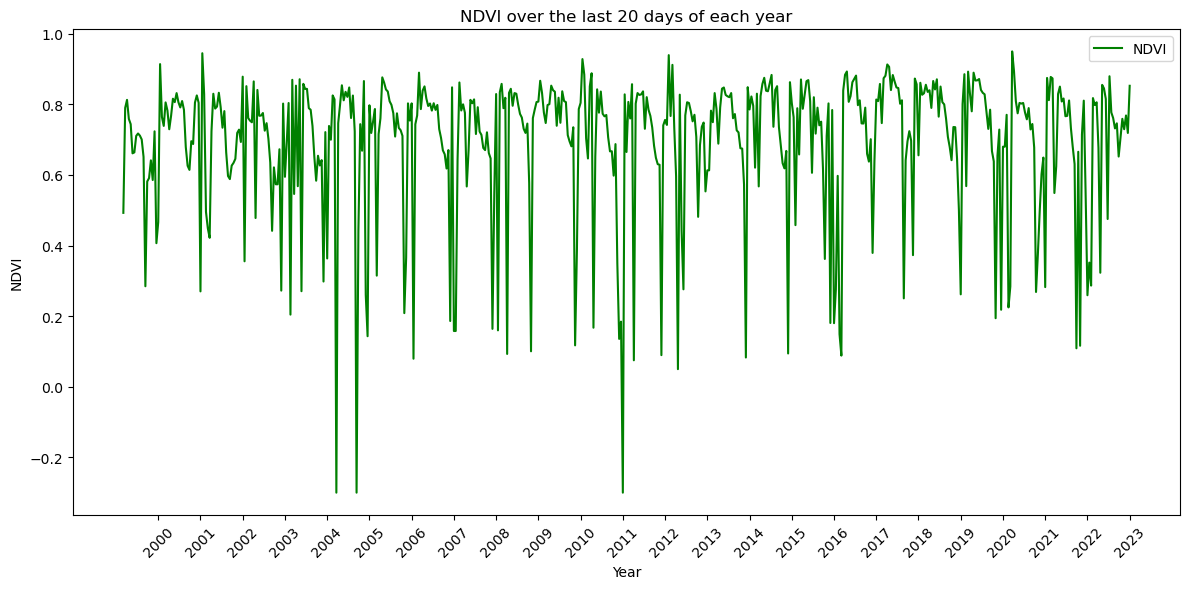

In [9]:
# Plotting NDVI
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    NDVI["Data"],
    NDVI["NDVI"],
    label="NDVI",
    color="green",
)
plt.title("NDVI over the last 20 days of each year")

plt.xlabel("Year")
plt.xticks(
    ticks=NDVI.groupby("Year").tail(1).index,
    labels=NDVI.groupby("Year").tail(1)["Year"],
)
plt.ylabel("NDVI")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# class MLPDataset(torch.utils.data.Dataset):
#     def __init__(self, ndvi_df, prod_df):
#         self.ndvi_df = ndvi_df
#         self.prod_df = prod_df

#     def __len__(self):
#         return self.ndvi_df["Year"].nunique()

#     def __getitem__(self, idx):
#         years = self.ndvi_df["Year"].sort_values().unique()
#         if idx >= len(years):
#             raise IndexError("Index out of range")
#         year = years[idx]
#         ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]["NDVI"].values
#         prod = self.prod_df[self.prod_df["Year"] == year][
#             "Productivity (kg/ha)"
#         ].values[0]
#         return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
#             prod, dtype=torch.float32
#         )


# dataset = MLPDataset(NDVI_last_20_per_year, PROD)
# dataset[0]

# train_size = len(dataset) - 8
# valid_size = 4
# test_size = 4
# train_dataset = torch.utils.data.Subset(dataset, range(train_size))
# valid_dateset = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size + valid_size, train_size + valid_size + test_size))

### 2.2. Preparar Datasets

#### 2.1.1. Normalização

In [11]:
from sklearn.preprocessing import StandardScaler

# Normalizer dados NDVI

NDVI["Year_norm"] = NDVI["Year"].copy()

ndvi_scaler = StandardScaler().fit(NDVI[["NDVI", "Year"]].values)
NDVI[["NDVI_norm", "Year_norm"]] = ndvi_scaler.transform(
    NDVI[["NDVI", "Year"]].values
)

NDVI


,Data,NDVI,Year,N_Observations,Date_sin,Date_cos,Year_norm,NDVI_norm
0,2000-02-18,0.4925,2000,20,0.733885,0.679273,-1.678564,-1.001186
1,2000-03-05,0.7898,2000,20,0.890617,0.454755,-1.678564,0.472129
2,2000-03-21,0.8125,2000,20,0.980575,0.196143,-1.678564,0.584623
3,2000-04-06,0.7585,2000,20,0.997018,-0.077175,-1.678564,0.317017
4,2000-04-22,0.7437,2000,20,0.938710,-0.344707,-1.678564,0.243674
...,...,...,...,...,...,...,...,...
544,2023-10-16,0.7588,2023,23,-0.970064,0.242850,1.660319,0.318504
545,2023-11-01,0.7294,2023,23,-0.867456,0.497513,1.660319,0.172808
546,2023-11-17,0.7683,2023,23,-0.699458,0.714673,1.660319,0.365583
547,2023-12-03,0.7188,2023,23,-0.478734,0.877960,1.660319,0.120278


In [12]:
# Normalizar produtividade
PROD["Year_norm"] = NDVI["Year"].copy()

prod_scaler = StandardScaler().fit(PROD[["Productivity (kg/ha)", "Year"]].values)
PROD[["Productivity_norm", "Year_norm"]] = prod_scaler.transform(
    PROD[["Productivity (kg/ha)", "Year"]].values
)
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha),Year_norm,Productivity_norm
26,2000,17424000,13200,1320.000000,-1.661325,0.425926
27,2001,17424000,13200,1320.000000,-1.516862,0.425926
28,2002,26325000,17550,1500.000000,-1.372399,1.171894
29,2003,13533000,17350,780.000000,-1.227936,-1.811979
30,2004,16560000,17250,960.000000,-1.083473,-1.066011
31,2005,16065000,17850,900.000000,-0.939010,-1.314667
32,2006,16065000,17850,900.000000,-0.794547,-1.314667
33,2007,16065000,17850,900.000000,-0.650084,-1.314667
34,2008,23958000,18150,1320.000000,-0.505621,0.425926
35,2009,20235000,17750,1140.000000,-0.361158,-0.320043


In [13]:
class DatasetYearOfLast(torch.utils.data.Dataset):
    """
    DatasetYearOfLast - Dataset para previsão de produtividade

    X: Sequências de tamanho <WINDOW_SIZE> de observações de NDVI consecutivas (normalizado -1 a +1)
    y: Produtividade no Ano da última observação

    Features:
    - Sequências de NDVI (Já vem normalizado entre 0 e 1 da fonte)
    - Sequências de dia do ano com codificação circular no formato de Tupla: (Seno, Cosseno)
    - Sequência de ano da observação normalizado por z-score

    Label:
    - Produtividade (kg/ha) normalizada por z-score, relativa ao ano da última observação
    """

    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df
        self.window_size = window_size

    def __len__(self):
        return len(self.ndvi_df) - self.window_size

    def __getitem__(self, idx):
        ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
            ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
        ].values

        year = self.ndvi_df.iloc[idx + self.window_size - 1]["Year"]
        prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )


# Test Dataset
train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"] <= 2016], PROD, LSTM_WINDOW_SIZE
)
validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[(NDVI["Year"] > 2016) & (NDVI["Year"] <= 2020)], PROD, LSTM_WINDOW_SIZE
)
test_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"] > 2020], PROD, LSTM_WINDOW_SIZE
)

print(validation_dataset_year_of_last[0][0].shape)
validation_dataset_year_of_last[0]

torch.Size([10, 4])


(tensor([[ 0.2751,  0.0000,  1.0000,  0.7893],
         [ 0.5973,  0.2720,  0.9623,  0.7893],
         [ 0.1489,  0.5234,  0.8521,  0.7893],
         [ 0.0882,  0.7354,  0.6776,  0.7893],
         [ 0.8388,  0.8920,  0.4521,  0.7893],
         [ 0.8836,  0.9813,  0.1925,  0.7893],
         [ 0.8929,  0.9967, -0.0817,  0.7893],
         [ 0.8069,  0.9369, -0.3496,  0.7893],
         [ 0.8232,  0.8065, -0.5913,  0.7893],
         [ 0.8625,  0.6153, -0.7883,  0.7893]]),
 tensor(0.8958))

In [14]:
class DatasetWeightedAverage(torch.utils.data.Dataset):
    """DatasetWeightedAverage - Dataset para previsão de produtividade

    X: Sequências de tamanho <WINDOW_SIZE> de observações de NDVI consecutivas (normalizado -1 a +1)
    y: Produtividade média ponderada entre a produtividade do ano da primeira observação e do ano da última observação
    - (normalizado por z-score)
    - A média é ponderada pela quantidade de observações do ano da primeira e do ano da última observação

    Features:
    - Sequências de NDVI (Já vem normalizado entre 0 e 1 da fonte)
    - Sequências de dia do ano com codificação circular no formato de Tupla: (Seno, Cosseno)
    - Sequência de ano da observação normalizado por z-score

    Label:
    - Produtividade (kg/ha) média ponderada entre o ano da primeira e do ano da última observação, normalizada por z-score
    """

    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df
        self.prod_df = prod_df
        self.window_size = window_size

    def __len__(self):
        return len(self.ndvi_df) - self.window_size

    def __getitem__(self, idx):
        ndvi = self.ndvi_df.iloc[idx : idx + self.window_size][
            ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
        ].values

        year_first = self.ndvi_df.iloc[idx]["Year"]
        year_last = self.ndvi_df.iloc[idx + self.window_size]["Year"]

        prod_first = self.prod_df[self.prod_df["Year"] == year_first][
            "Productivity_norm"
        ].values[0]
        prod_last = self.prod_df[self.prod_df["Year"] == year_last][
            "Productivity_norm"
        ].values[0]

        n_obs_first = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df.iloc[idx : idx + self.window_size]["Year"] == year_first
        ].shape[0]
        n_obs_last = self.ndvi_df.iloc[idx : idx + self.window_size].loc[
            self.ndvi_df["Year"] == year_last
        ].shape[0]

        # Ponderação
        prod = (n_obs_first * prod_first + n_obs_last * prod_last) / (
            n_obs_first + n_obs_last
        )
        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )
        
# Test Dataset
train_dataset_weighted_average = DatasetWeightedAverage(NDVI[NDVI["Year"] <= 2016], PROD, LSTM_WINDOW_SIZE)
validation_dataset_weighted_average = DatasetWeightedAverage(NDVI[(NDVI["Year"] > 2016) & (NDVI["Year"] <= 2020)], PROD, LSTM_WINDOW_SIZE)
test_dataset_weighted_average = DatasetWeightedAverage(NDVI[NDVI["Year"] > 2020], PROD, LSTM_WINDOW_SIZE)

validation_dataset_weighted_average[10]

(tensor([[ 0.8716,  0.3777, -0.9259,  0.7893],
         [ 0.8813,  0.1117, -0.9937,  0.7893],
         [ 0.7974, -0.1628, -0.9867,  0.7893],
         [ 0.8113, -0.4250, -0.9052,  0.7893],
         [ 0.7458, -0.6552, -0.7555,  0.7893],
         [ 0.7455, -0.8359, -0.5488,  0.7893],
         [ 0.7905, -0.9537, -0.3008,  0.7893],
         [ 0.6598, -0.9995, -0.0301,  0.7893],
         [ 0.6377, -0.9701,  0.2428,  0.7893],
         [ 0.7011, -0.8675,  0.4975,  0.7893]]),
 tensor(0.8958))

## 3. Model training

### 3.1. Multi-layer Perceptron

Essa rede é uma feedforward perceptron multi-layer comum (1 camada interna).

As entradas são os 20 últimos NDVIs do ano, a saída é a produtividade prevista (kg/ha).

In [15]:
mlp_network = nn.Sequential(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(MLP_WINDOW_SIZE * 4, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
)

def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.normal_(m.bias, mean=0.0, std=0.01)

mlp_network.apply(init_linear_weights)

# for name, param in mlp_network.named_parameters():
#     print(f"{name}: {param}")

# Step-by-step debug the MLP
# x = torch.randn(20, 4)
# print(f"Input shape: {x.shape}\n{x}\n")
# for i, layer in enumerate(mlp_network):
#     x = layer(x)
#     print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}\n{x}\n")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=40, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=1, bias=True)
)

In [16]:
mlp_network = mlp_network.to(device)
optimizer = optim.Adam(mlp_network.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

mlp_losses = []
best_loss = float("inf")
saved_epoch = 0

train_loader_weighted_average = torch.utils.data.DataLoader(
    train_dataset_weighted_average, batch_size=MLP_BATCH_SIZE, shuffle=True
)
validation_loader_weighted_average = torch.utils.data.DataLoader(
    validation_dataset_weighted_average, batch_size=4, shuffle=True
)

for i in trange(200):
    mlp_network.train()
    for ndvi, prod in train_loader_weighted_average:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()
        pred = mlp_network(ndvi)
        loss = loss_fn(pred.squeeze(dim=1), prod)
        loss.backward()
        optimizer.step()

    epoch_losses = []
    mlp_network.eval()
    with torch.no_grad():
        for ndvi, prod in validation_loader_weighted_average:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = mlp_network(ndvi)
            loss = loss_fn(pred.squeeze(dim=1), prod)
            epoch_losses.append(loss.item())

        if np.mean(epoch_losses) < best_loss:
            best_loss = np.mean(epoch_losses)
            saved_epoch = i + 1
            torch.save(mlp_network.state_dict(), "mlp.pth")

    mlp_losses.append(np.mean(epoch_losses))
print(f"\n\nSaved MLP model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

100%|██████████| 200/200 [02:13<00:00,  1.50it/s]



Saved MLP model	epoch: 152	validation loss: 0.7924


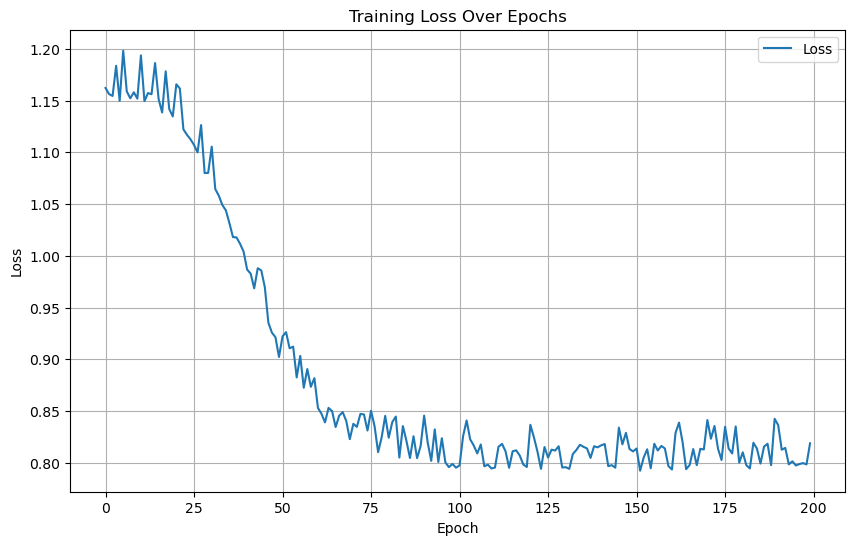

In [17]:
def plot_loss(losses):
    """
    Plots the training loss over epochs.

    Args:
        losses (list): List of loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(mlp_losses)

### 3.2. LSTM

In [18]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define model with Linear layer
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=LSTM_DROPOUT
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x, hidden_n=None, hidden_c=None):
        if hidden_n is None or hidden_c is None:
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])  # Get output of last time step
        else:
            out, (hidden_n, hidden_c) = self.lstm(x, (hidden_n, hidden_c))
            out = self.fc(out[:, -1, :])  # Get output of last time step
            return out, (hidden_n, hidden_c)


train_loader_weighted_average = torch.utils.data.DataLoader(
    train_dataset_weighted_average, batch_size=LSTM_BATCH_SIZE, shuffle=False
)
validation_loader_weighted_average = torch.utils.data.DataLoader(
    validation_dataset_weighted_average, batch_size=LSTM_BATCH_SIZE, shuffle=False
)


lstm_model = LSTMRegressor(
    input_size=4, hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS
).to(device)

for name, param in lstm_model.named_parameters():
    print(f"{name}: {param}")

def init_lstm_weights(m):
    if isinstance(m, nn.LSTM):
        nn.init.xavier_uniform_(m.weight_ih_l0)
        nn.init.xavier_uniform_(m.weight_hh_l0)

lstm_model.apply(init_lstm_weights)
lstm_model.apply(init_linear_weights)

optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

lstm_losses = []
best_loss = float("inf")
saved_epoch = 0


for i in range(LSTM_EPOCHS):
    h_n = torch.zeros(LSTM_NUM_LAYERS, 1, LSTM_HIDDEN_SIZE).to(device)  # Hidden state
    h_c = torch.zeros(LSTM_NUM_LAYERS, 1, LSTM_HIDDEN_SIZE).to(device)  # Cell state

    lstm_model.train()
    for ndvi, prod in train_loader_weighted_average:
        ndvi, prod = ndvi.to(device), prod.to(device)
        optimizer.zero_grad()

        pred, (h_n, h_c) = lstm_model(
            ndvi.unsqueeze(0), h_n.detach(), h_c.detach()
        )  # Add batch dimension: [1, seq_len, 3]
        # print(pred.shape)
        last_pred = pred[:, -1]  # Get the last prediction
        # print(last_pred.shape)
        loss = loss_fn(last_pred, prod.unsqueeze(0))  # Match shape: [1]
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        optimizer.step()

    epoch_losses = []
    lstm_model.eval()
    with torch.no_grad():
        for ndvi, prod in validation_loader_weighted_average:
            ndvi, prod = ndvi.to(device), prod.to(device)
            pred = lstm_model(ndvi.unsqueeze(0))
            last_pred = pred[:, -1]  # Get the last prediction
            loss = loss_fn(last_pred, prod.unsqueeze(0))
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        if avg_loss < best_loss:
            best_loss = avg_loss
            saved_epoch = i + 1
            torch.save(lstm_model.state_dict(), "lstm.pth")

    # if (i) % 10 == 0:
    print(f"Epoch {i+1}/{LSTM_EPOCHS} - Loss: {avg_loss:.4f}")
    lstm_losses.append(avg_loss)

print(f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}")

lstm.weight_ih_l0: Parameter containing:
tensor([[-0.1165, -0.0818,  0.0740, -0.1087],
        [-0.0833, -0.0518, -0.0783,  0.1024],
        [-0.0479, -0.0737, -0.1186,  0.0199],
        ...,
        [-0.1005,  0.0055,  0.1166, -0.0271],
        [ 0.0794,  0.1055,  0.0981, -0.1047],
        [-0.0885, -0.0548,  0.1130,  0.0263]], device='cuda:0',
       requires_grad=True)
lstm.weight_hh_l0: Parameter containing:
tensor([[ 0.0315, -0.0737, -0.1147,  ...,  0.0917,  0.0206,  0.0994],
        [ 0.0018, -0.0390,  0.0564,  ..., -0.1037, -0.0020, -0.0954],
        [-0.0232,  0.0395,  0.0846,  ...,  0.0882,  0.0507, -0.0626],
        ...,
        [ 0.0715,  0.0127, -0.1097,  ...,  0.0070,  0.0254,  0.0931],
        [-0.0176,  0.0054, -0.0776,  ...,  0.1213, -0.0796,  0.0209],
        [-0.0353, -0.0763, -0.0131,  ...,  0.0416,  0.0658, -0.0703]],
       device='cuda:0', requires_grad=True)
lstm.bias_ih_l0: Parameter containing:
tensor([ 0.0009,  0.0956,  0.0725,  0.0760, -0.0325,  0.0608, -0.09

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [ ]:
plot_loss(lstm_losses)